# Building an Image Classifier Deep Network applying Transfer Learning

In [1]:
# import the required libraries
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# from tensorflow.keras.preprocessing import image_dataset_from_directory
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tf.keras.utils
from PIL import Image
import numpy as np
import os
import base64
from io import BytesIO

2023-11-08 15:32:09.825122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 15:32:10.674862: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-11-08 15:32:10.674979: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-11-08 15:32:10.674996: W 

## Dataset creation

In [4]:
# dataset's directory path
directory = "../dataset/images/"

batch_size = 32
image_size = (160,160) # resize the images to 160x160

# create training and validation sets
# use image_dataset_from_directory to load the images
# set a validation split and specify the subset ('training' or 'validation')
# set the random seeds to match eachother (to avoid overlapping of the images in
# train and validation sets)

train_set = tf.keras.utils.image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=image_size,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_set = tf.keras.utils.image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=image_size,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 183 files belonging to 2 classes.
Using 147 files for training.
Found 183 files belonging to 2 classes.
Using 36 files for validation.


# Obtain Class names (labels)

In [5]:
# print some images
# use .class_names attribute to retrieve the classes of the images from the dicrectories names
class_names = train_set.class_names
print(class_names)

['tea-earl-grey', 'tea-lemon']


# Plot samples

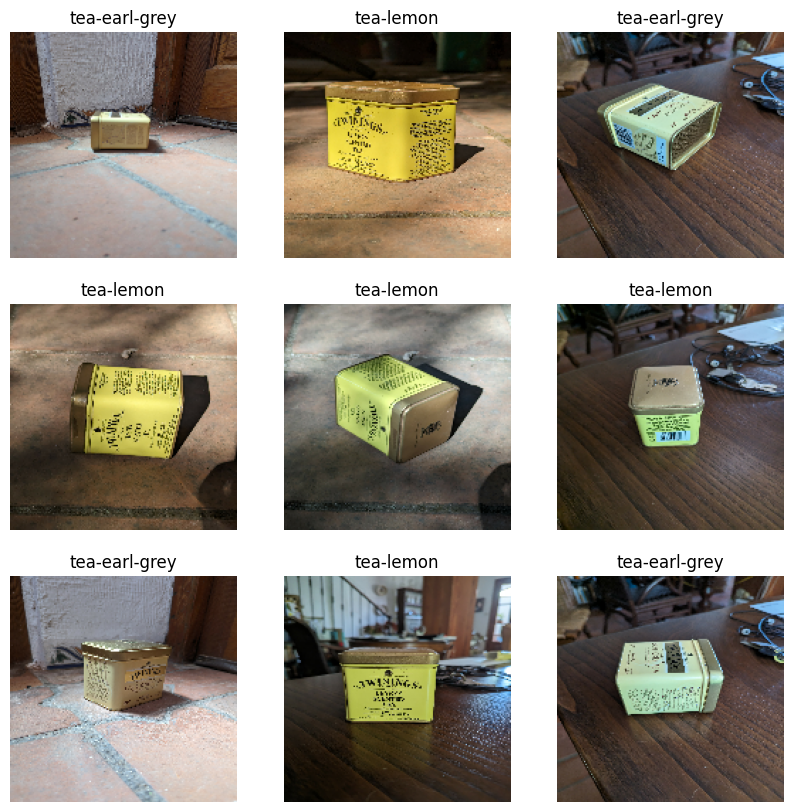

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1): # take 1 batch randomly
    for i in range(9): # print 9 images of that batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Import pre-trained model

In [7]:
# explore the MobileNetV2 network
image_shape = image_size + (3,)
pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=True,
                                               weights='imagenet')

14536120/14536120 [==============================] - 0s 0us/step


In [8]:
len(pre_trained_model.layers)

156

In [9]:
# load the pre-trained model without the final layers
image_shape = image_size + (3,)
pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
len(pre_trained_model.layers)

154

In [11]:
# normalize the inputs to the range [-1, 1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# freeze the base model by making it non trainable
pre_trained_model.trainable = False
# define the input layer
inputs = tf.keras.Input(shape=image_shape) 
# preprocess the inputs
x = preprocess_input(inputs)
# add the pre-trained (not trainable) model
x = pre_trained_model(x, training=False)
# add a pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# add a dropout layer for regularization
x = tf.keras.layers.Dropout(0.2)(x)
# add the output layer
# outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x)
# define the model with its inputs and outputs
model = tf.keras.Model(inputs, outputs)

# Compile Model

In [12]:
# compile the model
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              # loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train Model

In [13]:
# train the model
history = model.fit(train_set, validation_data=validation_set, epochs=10)

Epoch 1/10
5/5 [==============================] - 6s 481ms/step - loss: 0.7301 - accuracy: 0.5850 - val_loss: 0.5620 - val_accuracy: 0.7222
Epoch 2/10
5/5 [==============================] - 3s 277ms/step - loss: 0.4592 - accuracy: 0.7755 - val_loss: 0.4215 - val_accuracy: 0.8333
Epoch 3/10
5/5 [==============================] - 3s 276ms/step - loss: 0.3223 - accuracy: 0.8503 - val_loss: 0.3381 - val_accuracy: 0.8611
Epoch 4/10
5/5 [==============================] - 3s 257ms/step - loss: 0.2590 - accuracy: 0.8980 - val_loss: 0.2174 - val_accuracy: 0.9167
Epoch 5/10
5/5 [==============================] - 3s 258ms/step - loss: 0.1969 - accuracy: 0.9116 - val_loss: 0.1879 - val_accuracy: 0.9444
Epoch 6/10
5/5 [==============================] - 3s 273ms/step - loss: 0.1452 - accuracy: 0.9456 - val_loss: 0.1537 - val_accuracy: 0.9444
Epoch 7/10
5/5 [==============================] - 3s 257ms/step - loss: 0.1196 - accuracy: 0.9864 - val_loss: 0.1150 - val_accuracy: 0.9722
Epoch 8/10
5/5 [====

# Plot Loss/Accuracy

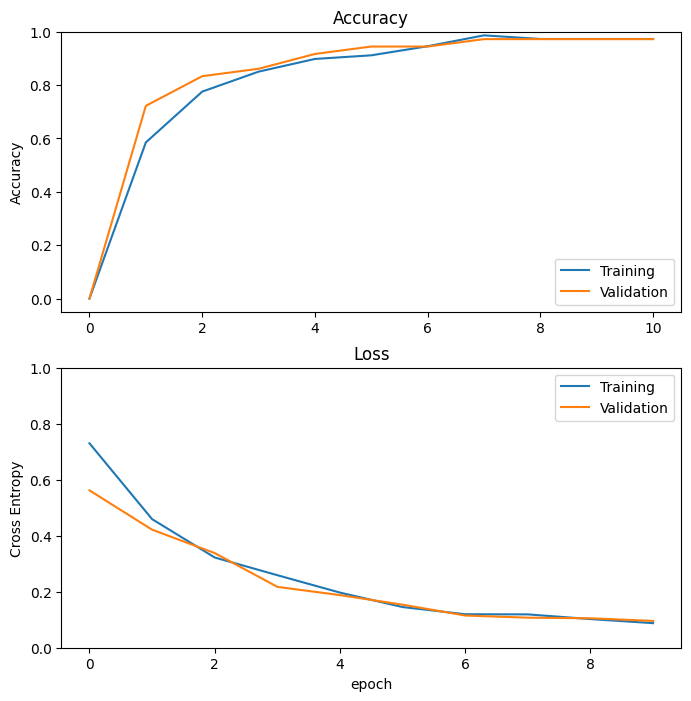

In [14]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

# Verify Tea Lemon prediction results

In [16]:
# from imageio import imread
# from skimage.transform import resize
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# predict images
test_path = "../dataset/images/tea-lemon"
test_imgs = os.listdir(test_path)


ti = len(test_imgs)
print("number of images: ", ti)

data = np.empty((ti, 160, 160, 3))

for i in test_imgs:
    image_path = os.path.join(test_path, i)
    # print(image_path)
    img = Image.open(image_path).convert('RGB')
    img = img.resize((160, 160), Image.LANCZOS)
    # img = img.resize((160, 160), Image.ANTIALIAS)
    img = np.asarray(img)
    # img = preprocess_input(img)
    # print(test_imgs.index(i))
    data[test_imgs.index(i)] = img
    
    
predictions = model.predict(data)

# print(predictions)
print(np.argmax(predictions, axis=1))
print("Above, should be all 1's.")

number of images:  99
4/4 [==============================] - 1s 107ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1]
Above, should be all 1's.


# Verify Tea Earl-Grey prediction results

In [17]:
# from imageio import imread
# from skimage.transform import resize
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# predict images
test_path = "../dataset/images/tea-earl-grey"
test_imgs = os.listdir(test_path)


ti = len(test_imgs)
print("number of images: ", ti)

data = np.empty((ti, 160, 160, 3))

for i in test_imgs:
    image_path = os.path.join(test_path, i)
    # print(image_path)
    img = Image.open(image_path).convert('RGB')
    img = img.resize((160, 160), Image.LANCZOS)
    # img = img.resize((160, 160), Image.ANTIALIAS)
    img = np.asarray(img)
    # img = preprocess_input(img)
    # print(test_imgs.index(i))
    data[test_imgs.index(i)] = img
    
    
predictions = model.predict(data)

# print(predictions)

print(np.argmax(predictions, axis=1))
print("Above, should be all 0's.")

number of images:  84
3/3 [==============================] - 0s 107ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
Above, should be all 0's.


# With Data Augmentation

In [18]:
# freeze the base model by making it non trainable
pre_trained_model.trainable = False
# define the input layer
inputs = tf.keras.Input(shape=image_shape) 
# apply data augmentation
x = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),
                         tf.keras.layers.RandomRotation(0.2)])(inputs)

# preprocess the augmented inputs
x = preprocess_input(x)
# add the pre-trained (not trainable) model
x = pre_trained_model(x, training=False)
# add a pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# add a dropout layer for regularization
x = tf.keras.layers.Dropout(0.2)(x)
# add the output layer
# outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x)
# define the model with its inputs and outputs
model_augmented = tf.keras.Model(inputs, outputs)

In [19]:
model_augmented.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

# Compile augmented model

In [20]:
# compile the model
base_learning_rate = 0.001
model_augmented.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              # loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# train the model
history_augmented = model_augmented.fit(train_set, validation_data=validation_set, epochs=20)

Epoch 1/20
5/5 [==============================] - 7s 428ms/step - loss: 0.6485 - accuracy: 0.6735 - val_loss: 0.5404 - val_accuracy: 0.7222
Epoch 2/20
5/5 [==============================] - 3s 259ms/step - loss: 0.4550 - accuracy: 0.7755 - val_loss: 0.5678 - val_accuracy: 0.7222
Epoch 3/20
5/5 [==============================] - 3s 273ms/step - loss: 0.3298 - accuracy: 0.8639 - val_loss: 0.4660 - val_accuracy: 0.7778
Epoch 4/20
5/5 [==============================] - 3s 258ms/step - loss: 0.2253 - accuracy: 0.9388 - val_loss: 0.2930 - val_accuracy: 0.8611
Epoch 5/20
5/5 [==============================] - 3s 257ms/step - loss: 0.2687 - accuracy: 0.8844 - val_loss: 0.2888 - val_accuracy: 0.8889
Epoch 6/20
5/5 [==============================] - 3s 275ms/step - loss: 0.1508 - accuracy: 0.9660 - val_loss: 0.2333 - val_accuracy: 0.8889
Epoch 7/20
5/5 [==============================] - 3s 257ms/step - loss: 0.1934 - accuracy: 0.9456 - val_loss: 0.2031 - val_accuracy: 0.9167
Epoch 8/20
5/5 [====

In [21]:
# predict images
test_path = "../dataset/images/tea-lemon"
test_imgs = os.listdir(test_path)


ti = len(test_imgs)
print("number of images: ", ti)

data = np.empty((ti, 160, 160, 3))

for i in test_imgs:
    image_path = os.path.join(test_path, i)
    # print(image_path)
    img = Image.open(image_path).convert('RGB')
    img = img.resize((160, 160), Image.LANCZOS)
    # img = img.resize((160, 160), Image.ANTIALIAS)
    img = np.asarray(img)
    # img = preprocess_input(img)
    # print(test_imgs.index(i))
    data[test_imgs.index(i)] = img
    
    
predictions = model_augmented.predict(data)

# print(predictions)
print(np.argmax(predictions, axis=1))
print("Above, should be all 1's.")
print("Results should have improved after augmentation")

number of images:  99
4/4 [==============================] - 1s 105ms/step
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1]
Above, should be all 1's.
Results should have improved after augmentation


# test single image

In [99]:
testfile = "../dataset/images/tea-earl-grey/PXL_20230803_124233750.MP.jpg"
testfile = "../dataset/images/tea-lemon/PXL_20230803_153317298.jpg"

img = Image.open(testfile).convert('RGB')
img = img.resize((160, 160), Image.LANCZOS)
img = np.asarray(img)
# print(img)

mydata = np.empty((1, 160, 160, 3))
mydata[0] = img

# print(mydata)

mypredition = model_augmented.predict(mydata)

print(mypredition)
print(np.argmax(mypredition, axis=1))

1/1 [==============================] - 0s 31ms/step
[[0.5767427 0.8080597]]
[1]


# Save augmented model

In [100]:
tf.saved_model.save(model_augmented, "../models/tea_model/1")

INFO:tensorflow:Assets written to: ../models/tea_model/1/assets


INFO:tensorflow:Assets written to: ../models/tea_model/1/assets


# Infer saved augmented model

### Load model

In [127]:
smodel = tf.saved_model.load("../models/tea_model/1")
# smodel = tf.keras.models.load_model('saved_model/tea_model')

# smodel = tf.saved_model.load("saved_model/tea_model_b64")
# This is the current signature, that only accepts image tensors as input
signature = smodel.signatures["serving_default"]

print(signature)

ConcreteFunction signature_wrapper(*, input_4)
  Args:
    input_4: float32 Tensor, shape=(None, 160, 160, 3)
  Returns:
    {'dense_1': <1>}
      <1>: float32 Tensor, shape=(None, 2)


### Obtain In/Out keys

In [128]:
# get inputs, and find the second one (first one is empty)
iterInputs = iter(signature.structured_input_signature)
signIn = next(iterInputs)
signIn = next(iterInputs)

# get the key
keyIn = list(signIn.keys())[0]
print(keyIn)

# obtain the key name of the output (typically 'dense_X')
keyOut = next(iter(signature.structured_outputs))
print(keyOut)

input_4
dense_1


### Load image and predict

In [129]:
testfile = "../dataset/images/tea-earl-grey/PXL_20230803_124233750.MP.jpg"
# testfile = "../dataset/images/tea-lemon/PXL_20230803_153317298.jpg"

# load test image
content = tf.io.read_file(testfile)
image = tf.image.decode_jpeg(content,channels=3)

# resize image
image = tf.image.resize(image, [160, 160])

# expand dimension to match signature
image = tf.expand_dims(image, 0)

# get predictor function
f = smodel.signatures["serving_default"]

# prepare predictor arguments
kwargs = {keyIn: image}

# predict
myprediction = f(**kwargs)

print(myprediction)
print("predicted class: ", np.argmax(myprediction[keyOut],axis=1))

# print(type(tf.argmax(myprediction[keyOut])))

# # print(tf.argmax(myprediction,axis=1))
# print(tf.argmax(myprediction[keyOut],axis=1))

# print(mypredition)
# print(tf.argmax(myprediction[keyOut], axis=1))

{'dense_1': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.9690815, 0.0255617]], dtype=float32)>}
predicted class:  [0]


# Save model with Base64 Signature

### Load labels

In [130]:
print(class_names)
labels = tf.constant([class_names])
print(labels)

['tea-earl-grey', 'tea-lemon']
tf.Tensor([[b'tea-earl-grey' b'tea-lemon']], shape=(1, 2), dtype=string)


### Load augmented model

In [131]:
smodel = tf.saved_model.load("../models/tea_model/1")

# This is the current signature, that only accepts image tensors as input
signature = smodel.signatures["serving_default"]
print(signature)

# obtain the key name of the output (typically 'dense_X')
keyOutput = next(iter(signature.structured_outputs))

@tf.function()
def my_predict(image_b64):

    # get content
    content = image_b64[0]
    
    # decode image    
    image = tf.image.decode_jpeg(content,channels=3)
    # tf.compat.v1.enable_eager_execution()
    
    # resize image
    image = tf.image.resize(image, [160, 160])
    
    # expand dimension to match signature
    image = tf.expand_dims(image, 0)
    
    # execute prediction
    prediction = signature(image)

    # obtain index of maximum probability prediction
    idx = tf.argmax(prediction[keyOutput],axis=1)
    
    # obtain the label for given index
    label = tf.gather(labels, idx, batch_dims=1)

    # obtain probability from Tensor
    probability = prediction[keyOutput][0,idx[0]]
    
    # combine result in String Tensor format with [label,probability]
    result = tf.concat([label, [tf.as_string(probability)]], axis=0)
    
    # return result_tensor
    return result

# Create new signature, to read b64 images
new_signature = my_predict.get_concrete_function(
    image_b64=tf.TensorSpec(name="image_b64", shape=[1], dtype=tf.string)
)

# Save model with Base64 input signature
tf.saved_model.save(
    smodel,
    export_dir="../models/tea_model_b64/1",
    signatures=new_signature
)

ConcreteFunction signature_wrapper(*, input_4)
  Args:
    input_4: float32 Tensor, shape=(None, 160, 160, 3)
  Returns:
    {'dense_1': <1>}
      <1>: float32 Tensor, shape=(None, 2)


INFO:tensorflow:Assets written to: ../models/tea_model_b64/1/assets


INFO:tensorflow:Assets written to: ../models/tea_model_b64/1/assets


# Test Base64 Model with single image

In [132]:
smodel = tf.saved_model.load("../models/tea_model_b64/1")

# Load model's signature
signature = smodel.signatures["serving_default"]

print(signature)

ConcreteFunction signature_wrapper(*, image_b64)
  Args:
    image_b64: string Tensor, shape=(1,)
  Returns:
    {'output_0': <1>}
      <1>: string Tensor, shape=(2,)


### Run Inference

In [134]:
testfile = "../dataset/images/tea-earl-grey/PXL_20230803_124233750.MP.jpg"
# testfile = "../dataset/images/tea-lemon/PXL_20230803_153317298.jpg"

# load test image
content = tf.io.read_file(testfile)

# reshape to signature's expected dimensions
content = tf.reshape(content, shape = [1])

# obtain signature
f = smodel.signatures["serving_default"]

# run prediction
myprediction = f(image_b64=content)
print(myprediction)

{'output_0': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'tea-earl-grey', b'0.969082'], dtype=object)>}
